# 20기 Time Series 정규세션 과제

- 제출자: 20기 황태연
- 제출 일자: 2023.08.29. (화)

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.

### Box-Jenkins 방법론
<img src="01.png">

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults

C:\Users\Poco\AppData\Local\Temp\ipykernel_37624\2309472473.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 데이터 불러오기

In [6]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


# 1. 식별

- ARIMA 모델을 이용하려면 데이터가 정상성을 가져야 합니다. 그래프(**시계열도**)를 출력하여 추세, 계절성 등이 있는지 확인해봅시다.

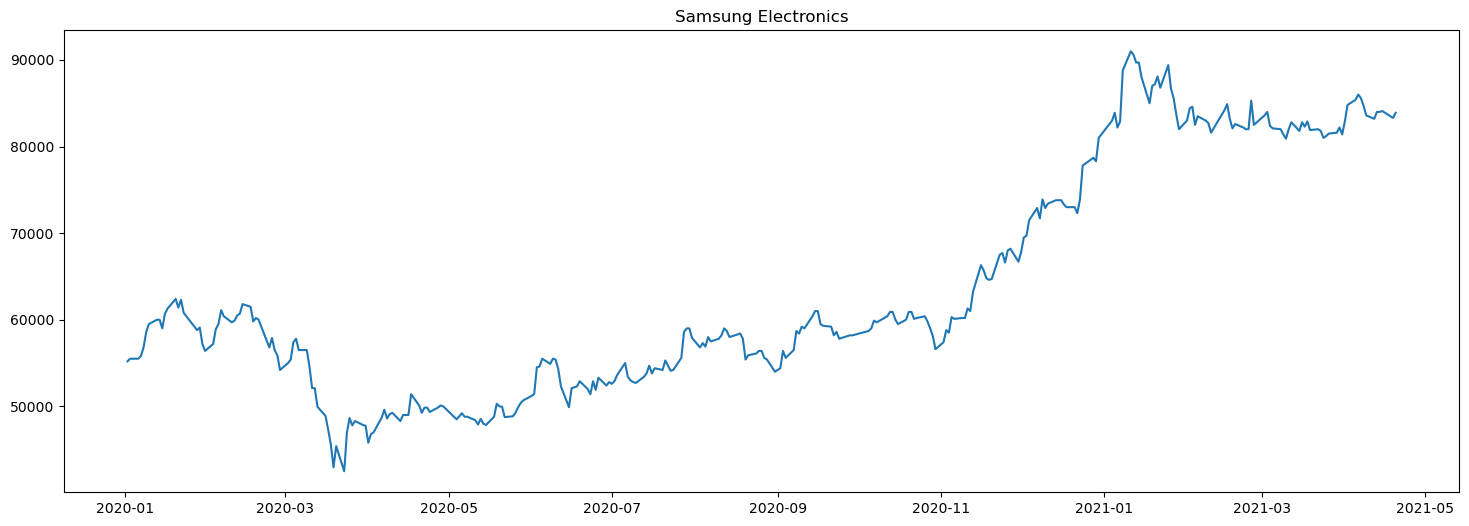

In [11]:
plt.figure(figsize=(18, 6))
plt.plot(samsung_df.index, samsung_df)
plt.xlabel=("day")
plt.ylabel=("price")
plt.title("Samsung Electronics")
plt.show()

- 그래프를 그려보니 추세가 있는 것으로 보입니다. 이를 통해 정상성을 가지지 않는다고 분석할 수 있습니다.

- 정상성을 가지는지 확인해보기 위해서는 **ACF**, **PACF**을 이용할 필요가 있습니다.
- 먼저 **ACF(자기 상관 함수)**를 이용하여 정상성을 가지는지 분석해보겠습니다.

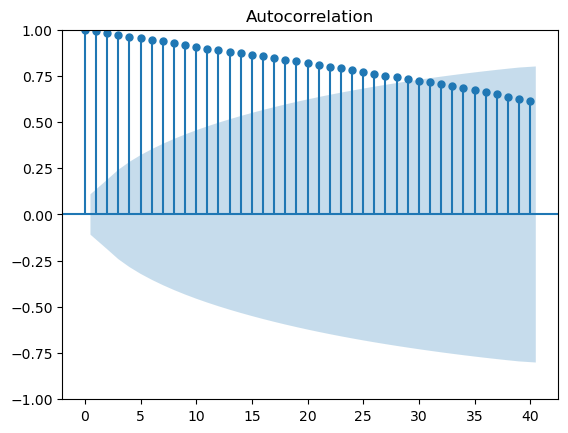

In [19]:
plot_acf(samsung_df, lags=40)
plt.show()

- 파란 영역을 벗어나면 자기 상관 관계가 있다고 볼 수 있습니다. 즉, 많은 Lag에서 파란 영역을 벗어나므로 이 데이터는 정상성을 가지지 않습니다.

- 이번에는 **PACF(부분 자기 상관 함수)**를 이용하여 정상성을 가지는지 분석해보겠습니다.

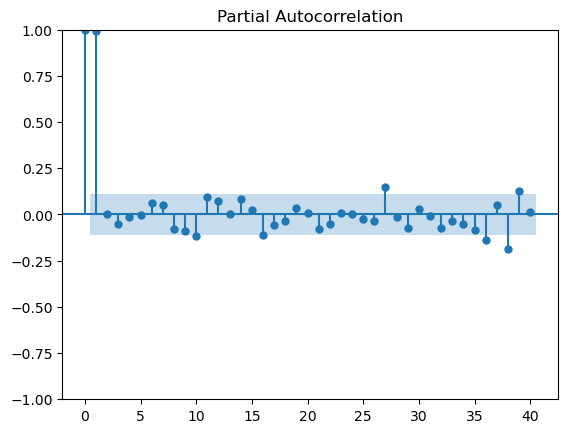

In [20]:
plot_pacf(samsung_df, lags=40)
plt.show()

- PACF 역시 파란 영역을 벗어나는 Lag가 중간중간마다 발생하고 있으나, 상당히 미미한 차이입니다. 시간의 효과를 제거하면 자기 상관 관계가 거의 없음을 확인할 수 있습니다.

- ACF로부터 데이터의 차분의 필요성을 알았으니, **1차 차분**을 진행합니다.

In [22]:
samsung_df_1 = samsung_df.diff()
samsung_df_1

,price
day,
2020-01-02,NaN
2020-01-03,300.0
2020-01-06,0.0
2020-01-07,300.0
2020-01-08,1000.0
...,...
2021-04-14,0.0
2021-04-15,100.0
2021-04-16,-200.0


- 맨 앞에 NaN 데이터가 발생했으므로 제거해줍니다.

In [24]:
samsung_df_1 = samsung_df_1.dropna()
samsung_df_1

,price
day,
2020-01-03,300.0
2020-01-06,0.0
2020-01-07,300.0
2020-01-08,1000.0
2020-01-09,1800.0
...,...
2021-04-14,0.0
2021-04-15,100.0
2021-04-16,-200.0


- 데이터의 그래프(**시계열도**), **ACF**, **PACF**를 확인해보겠습니다.

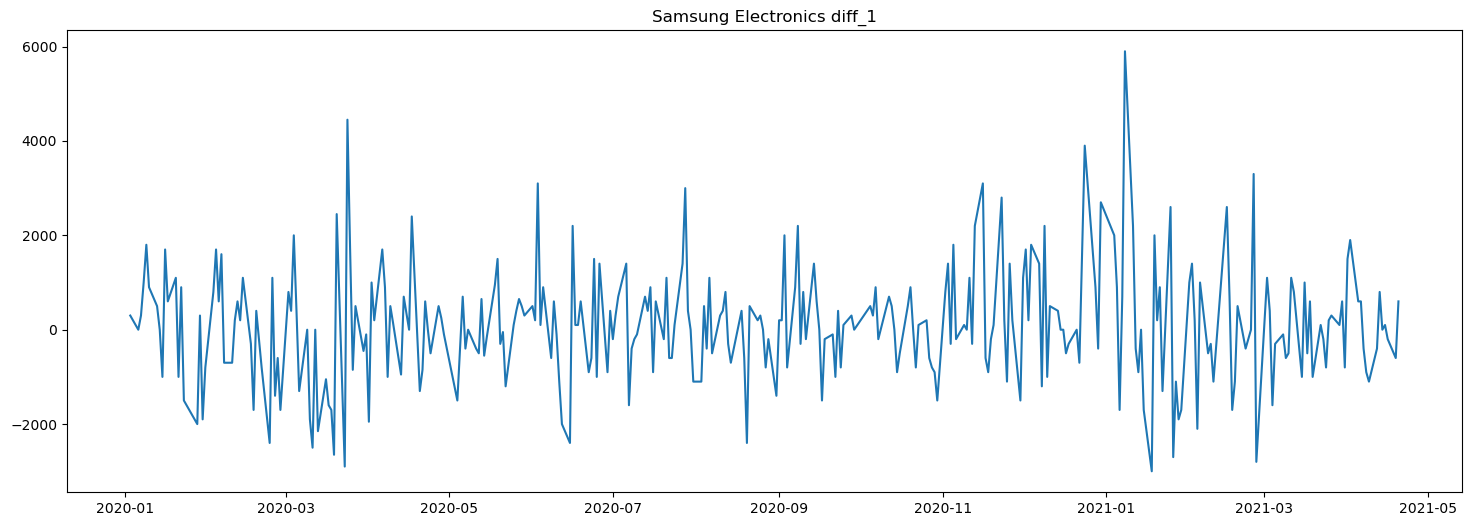

In [26]:
plt.figure(figsize=(18, 6))
plt.plot(samsung_df_1.index, samsung_df_1)
plt.xlabel=("day")
plt.ylabel=("price")
plt.title("Samsung Electronics diff_1")
plt.show()

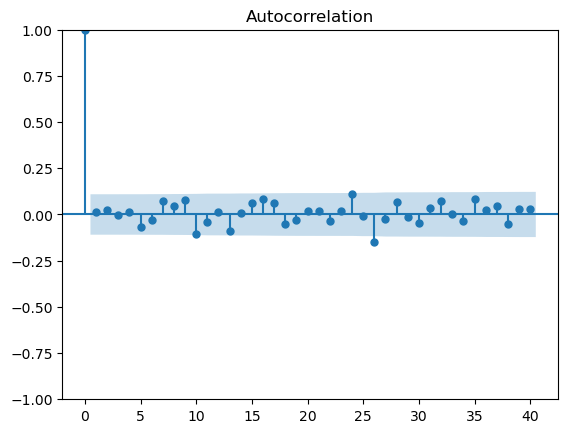

In [27]:
plot_acf(samsung_df_1, lags=40)
plt.show()

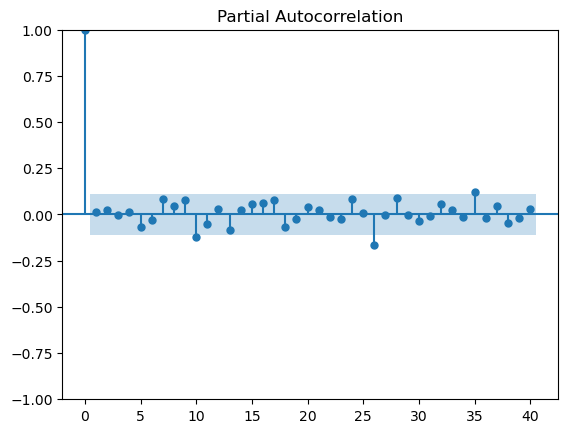

In [29]:
plot_pacf(samsung_df_1, lags=40)
plt.show()

- 1차 차분을 진행한 데이터는 ACF, PACF 그래프를 통해 자기 상관 관계가 거의 없음을 확인할 수 있습니다.
- 최종적으로 차분은 1로 결정하기로 하고, 추정 단계로 넘어갑니다.

# 2. 추정 & 진단

- 훈련 데이터와 테스트 데이터를 9:1 비율로 나누겠습니다.

In [172]:
idx = int(len(samsung_df)*0.9)
df_train = samsung_df.iloc[:idx]
df_test = samsung_df.iloc[idx:]

print(df_train.shape, df_test.shape)

(289, 1) (33, 1)


- 차분을 1로 하는 최적의 ARIMA 모델을 찾아봅시다.

In [215]:
model = auto_arima(df_train, d=1, D=1, seasonal=True, m=4, trace=True) # m=4는 4분기를 의미함.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=5008.034, Time=0.55 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=5055.964, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=5034.811, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=5025.738, Time=0.07 sec
 ARIMA(2,1,2)(0,1,1)[4]             : AIC=inf, Time=0.46 sec
 ARIMA(2,1,2)(1,1,0)[4]             : AIC=inf, Time=0.50 sec
 ARIMA(2,1,2)(2,1,1)[4]             : AIC=5009.806, Time=0.85 sec
 ARIMA(2,1,2)(1,1,2)[4]             : AIC=5010.574, Time=0.75 sec
 ARIMA(2,1,2)(0,1,0)[4]             : AIC=inf, Time=0.23 sec
 ARIMA(2,1,2)(0,1,2)[4]             : AIC=5014.073, Time=0.73 sec
 ARIMA(2,1,2)(2,1,0)[4]             : AIC=inf, Time=0.81 sec
 ARIMA(2,1,2)(2,1,2)[4]             : AIC=inf, Time=0.93 sec
 ARIMA(1,1,2)(1,1,1)[4]             : AIC=inf, Time=0.51 sec
 ARIMA(2,1,1)(1,1,1)[4]             : AIC=inf, Time=0.46 sec
 ARIMA(3,1,2)(1,1,1)[4]             : AIC=5009.811, Time=0.68 sec
 A

- AIC(Akaike information criterion)는 낮을수록 좋으며, 가장 적합한 ARIMA 모델은 ARIMA(2, 1, 2)(1, 1, 1)[4]이다.

In [217]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  289
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 4)   Log Likelihood               -2497.017
Date:                             Tue, 29 Aug 2023   AIC                           5008.034
Time:                                     18:59:35   BIC                           5033.576
Sample:                                          0   HQIC                          5018.274
                                             - 289                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7974      0.081      9.814      0.000       0.638       0.957
ar.L2         -0.9725      

# 3. 예측

- ARIMA 모델의 예측을 살펴보겠습니다.

In [222]:
model_fit = model.fit(df_train)
pred = model_fit.predict(n_periods=len(df_test))

In [228]:
df_pred = pd.DataFrame(pred.values, columns=['price'], index=df_test.index)
df_pred

,price
day,
2021-03-05,80857.667482
2021-03-08,81262.665046
2021-03-09,81598.799141
2021-03-10,81115.788047
2021-03-11,80252.809894
2021-03-12,80236.857364
2021-03-15,80473.621880
2021-03-16,80578.322266
2021-03-17,80137.477640


In [229]:
df_final = pd.concat([df_train, df_pred], axis=0)
df_final

,price
day,
2020-01-02,55200.000000
2020-01-03,55500.000000
2020-01-06,55500.000000
2020-01-07,55800.000000
2020-01-08,56800.000000
...,...
2021-04-14,81492.739895
2021-04-15,81154.473911
2021-04-16,81330.416646


- 이제 예측한 결과와 정답을 함께 그래프로 살펴보겠습니다.

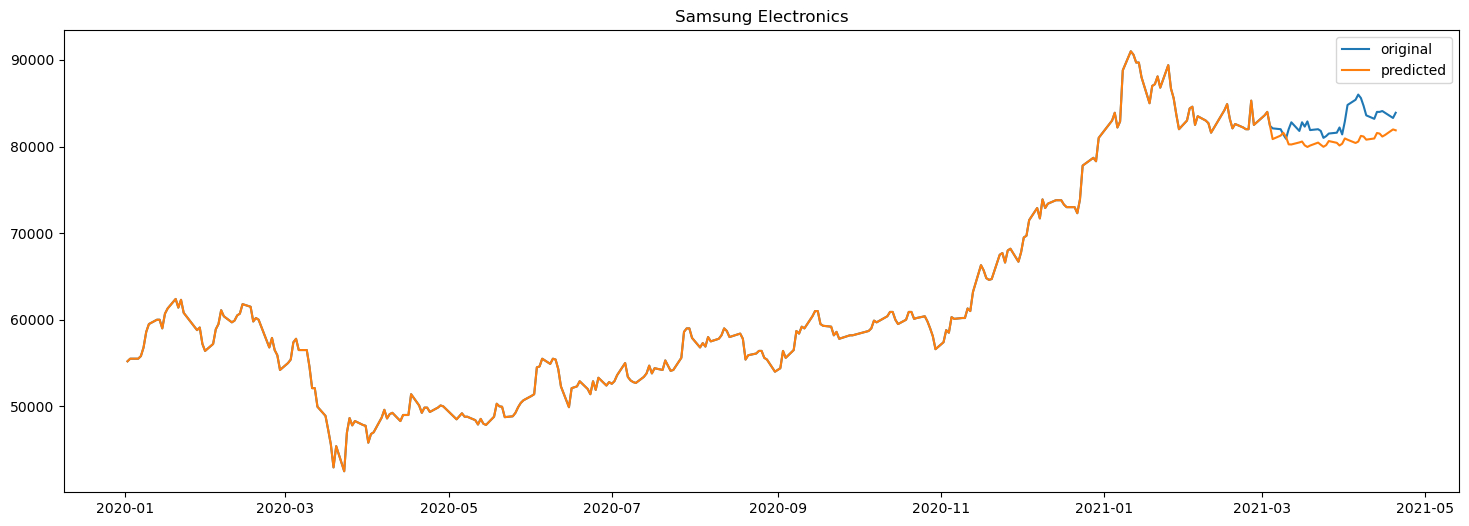

In [232]:
plt.figure(figsize=(18, 6))
plt.plot(samsung_df.index, samsung_df, label='original')
plt.plot(df_final.index, df_final, label='predicted')
plt.xlabel=("day")
plt.ylabel=("price")
plt.legend()
plt.title("Samsung Electronics")
plt.show()

- 위 결과는 2021-03-04 까지의 분석을 통해 이후 33영업일을 예측한 결과입니다.
- 주식 데이터는 원래 예측하는 것이 거의 불가능한 시계열 데이터로 알려져있습니다.
    - 만약 1영업일씩 예측하는 모델을 설계한다고 하더라도 그래프로 그리면 비슷할 뿐, 하루씩 밀리는 형태의 그래프가 그려지기 때문에 적절한 시계열 예측이라고 보기 어렵습니다.